In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

import ipdb

import bda_utils

# Load and assemble data

In [2]:
_, Xt = bda_utils.load_data(if_weekday=1, if_interdet=1)
Xt, Xt_min, Xt_max = bda_utils.normalize2D(Xt)

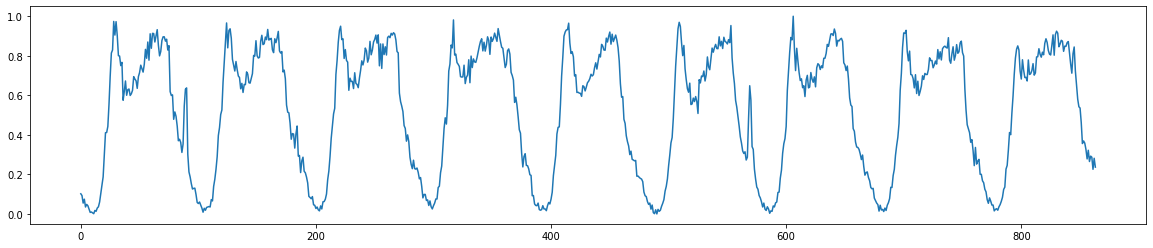

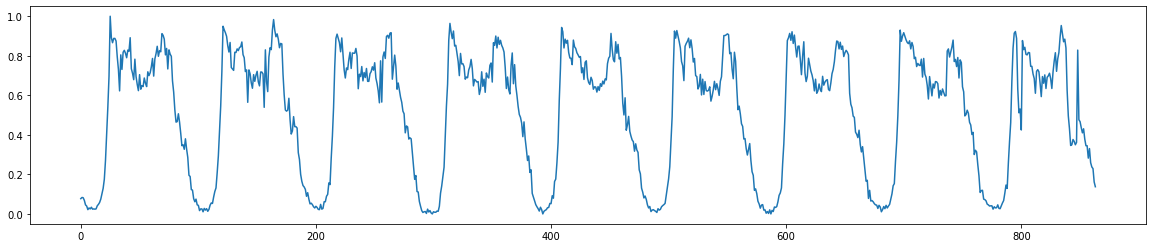

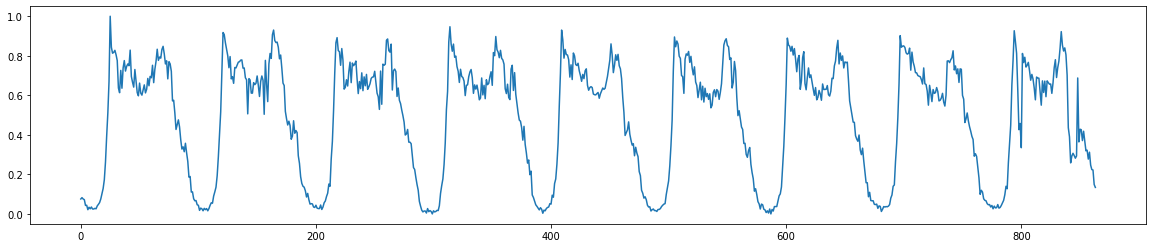

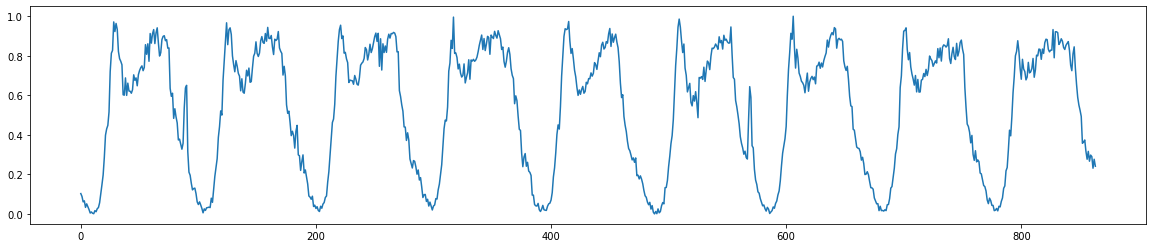

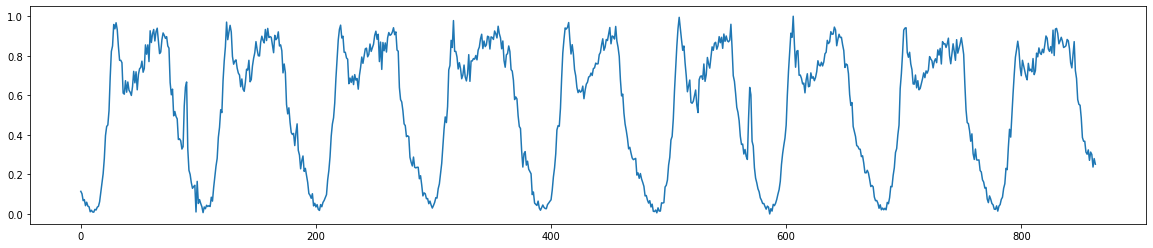

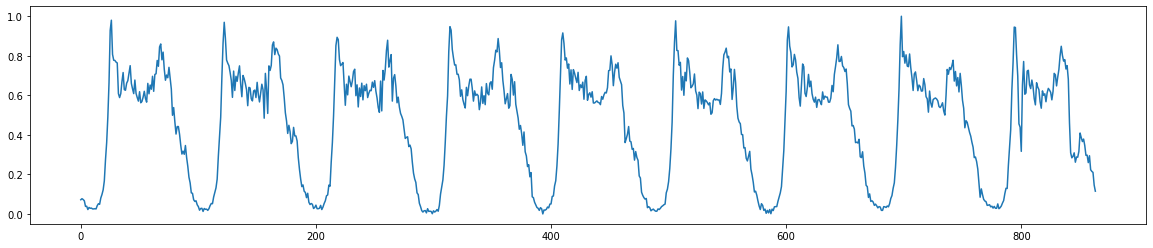

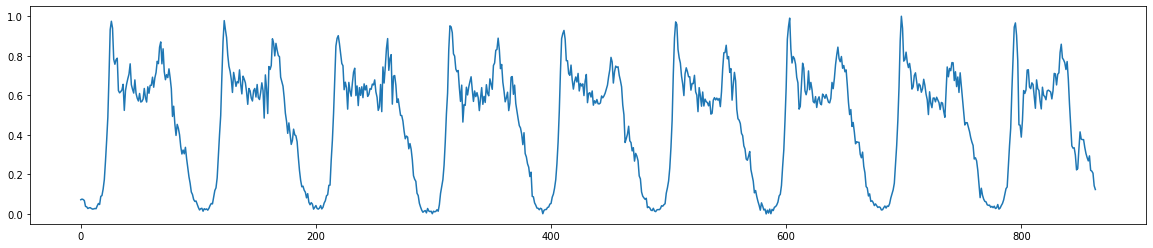

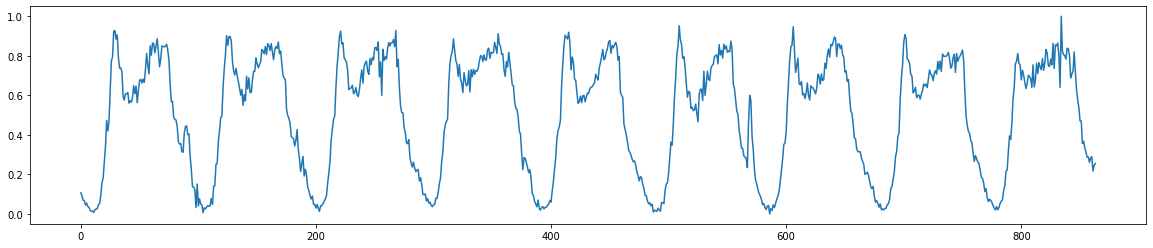

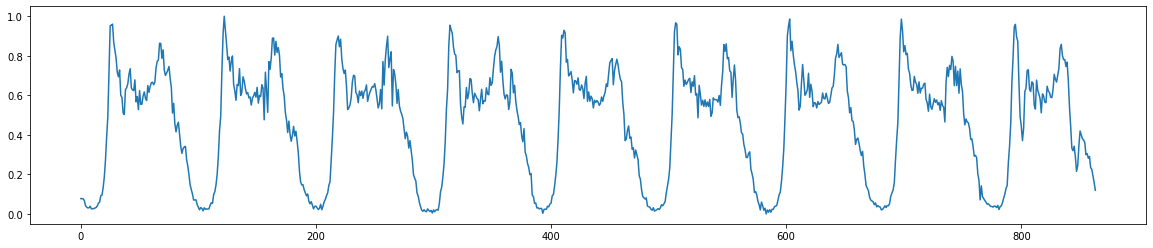

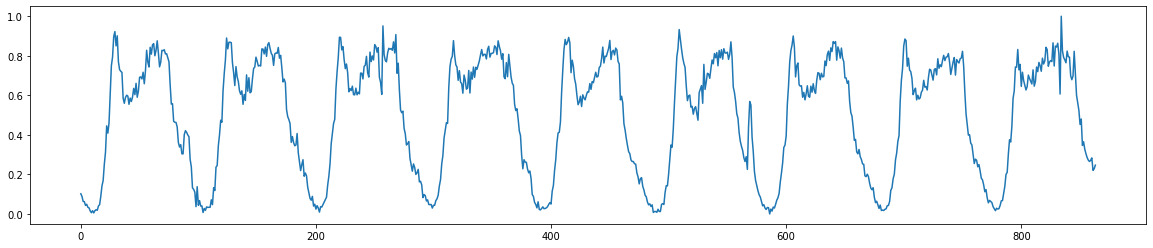

In [3]:
for i in range(Xt.shape[1]):
    plt.figure(figsize=[20,4])
    plt.plot(Xt[:, i])

In [4]:
label_seq_len = 3
# batch_size = full batch
seq_len = 12
reduced_dim = 4
inp_dim = Xt.shape[1]
label_dim = Xt.shape[1]
hid_dim = 12
layers = 1
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

In [5]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,10,10,3,12,4,12,1,3


In [6]:
Xt_train, Yt_train = bda_utils.sliding_window(Xt, Xt, seq_len, 1)
day_train_t = 1
Xt_valid = Xt_train.copy()[int(96*day_train_t):, :]
Xt_train = Xt_train.copy()[:int(96*day_train_t), :]
Yt_valid = Yt_train.copy()[int(96*day_train_t):, :]
Yt_train = Yt_train.copy()[:int(96*day_train_t), :]

In [7]:
batch_size = 1960

train_x = Xt_train
train_y = Yt_train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x = torch.tensor(train_x[:, :, :6], dtype=torch.float32).to(device)
train_y = torch.tensor(train_y[:, :, :], dtype=torch.float32).to(device)
Xt_valid = torch.tensor(Xt_valid[:, :, :6], dtype=torch.float32).to(device)
Yt_valid = torch.tensor(Yt_valid[:, :, :], dtype=torch.float32).to(device)

print(train_x.shape)
print(train_y.shape)
print('\n')
print(Xt_valid.shape)
print(Yt_valid.shape)

train_dataset = TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)
train_iter = iter(train_loader)

torch.Size([96, 12, 6])
torch.Size([96, 1, 10])


torch.Size([756, 12, 6])
torch.Size([756, 1, 10])


# Learn

In [8]:
# build model
from bda_utils import traff_net
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = traff_net(inp_dim-reduced_dim, label_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)
train_loss_set = []
val_loss_set = []

det = 5  # which detector to visualize

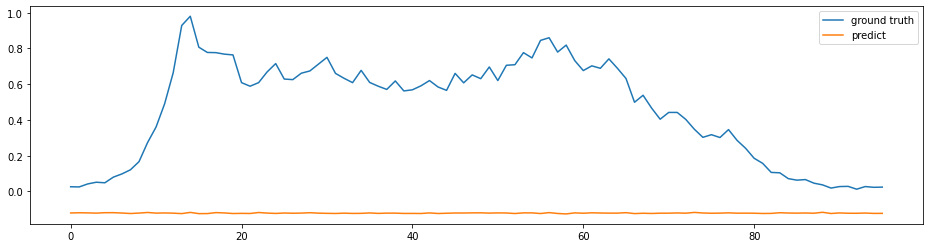

Epoch No. 0 success, loss: 0.36539, val loss: 0.33093


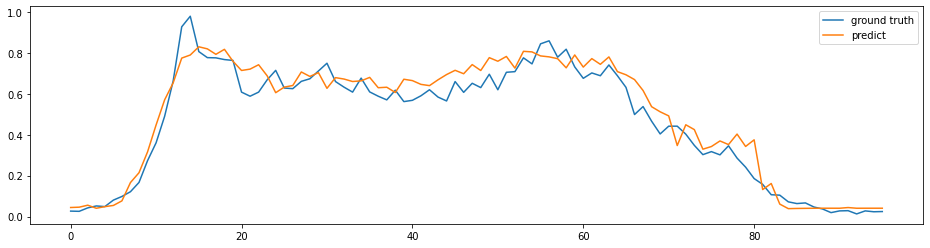

Epoch No. 200 success, loss: 0.00533, val loss: 0.00555


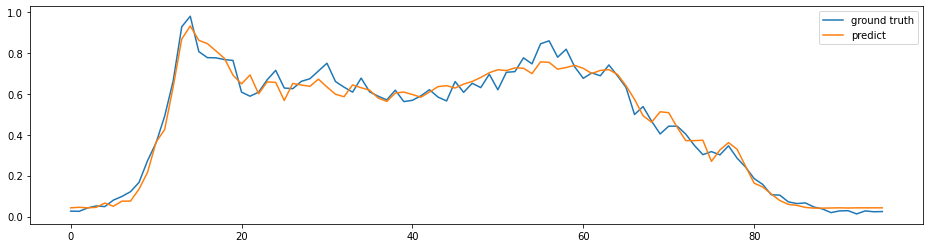

Epoch No. 400 success, loss: 0.00233, val loss: 0.00592


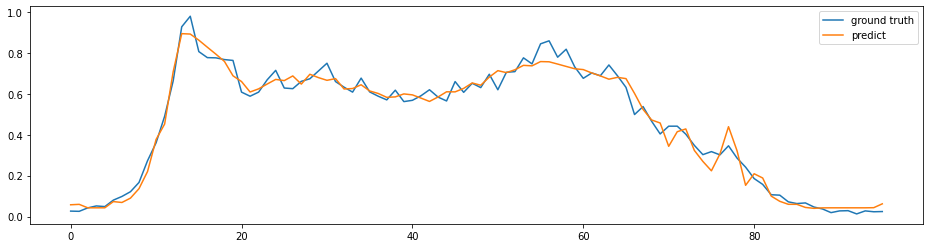

Epoch No. 600 success, loss: 0.00213, val loss: 0.00612


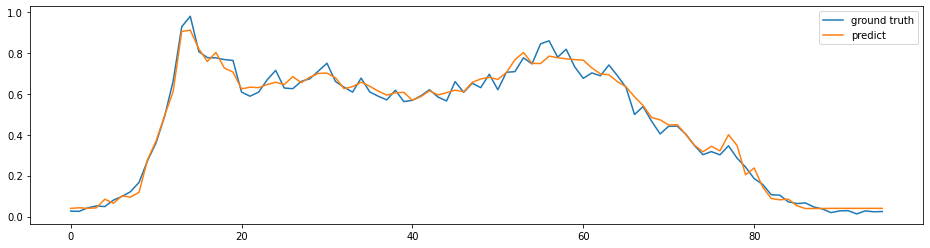

Epoch No. 800 success, loss: 0.00138, val loss: 0.00598


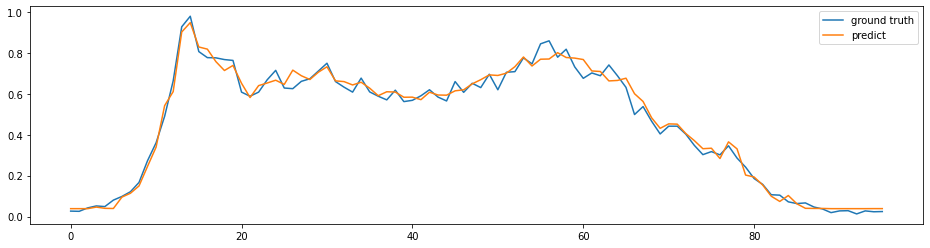

Epoch No. 1000 success, loss: 0.00111, val loss: 0.00603


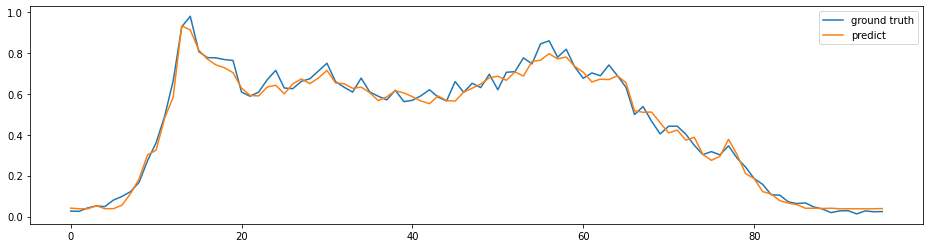

Epoch No. 1200 success, loss: 0.00125, val loss: 0.00703


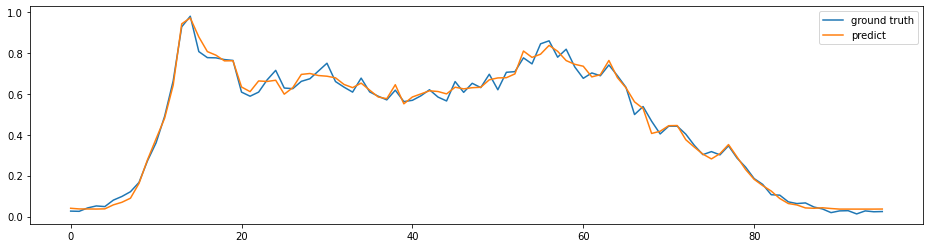

Epoch No. 1400 success, loss: 0.00083, val loss: 0.00642


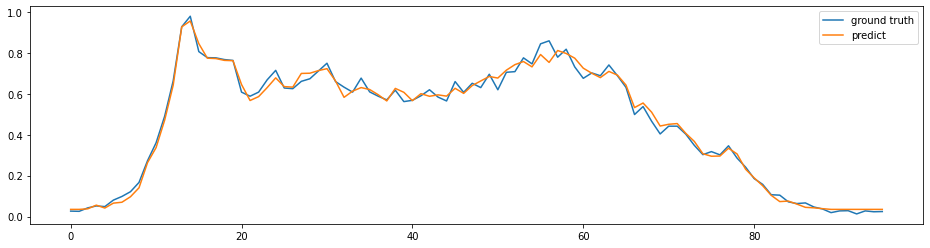

Epoch No. 1600 success, loss: 0.00074, val loss: 0.00601


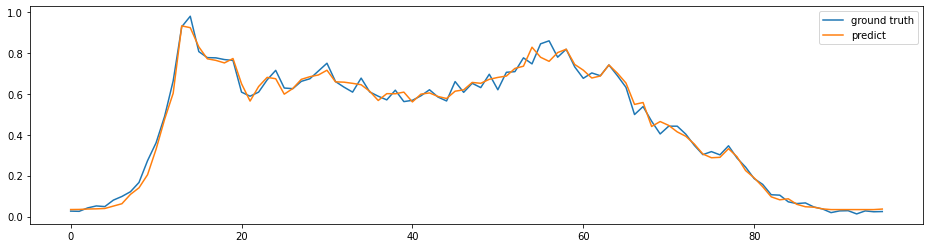

Epoch No. 1800 success, loss: 0.00076, val loss: 0.00651


In [9]:
# train
net.train()

epochs = 2000

for e in range(epochs):
    for i in range(len(train_loader)):
        try:
            data, label = train_iter.next()
        except:
            train_iter = iter(train_loader)
            data, label = train_iter.next()
#         ipdb.set_trace()
        out = net(data)
#         print(out.shape)
#         print(label.shape)
        loss = criterion(out, label[:, 0, :])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        val_out = net(Xt_valid)
#         print(val_out.shape)
#         print(Yt_valid.shape)
        val_loss = criterion(val_out, Yt_valid[:, 0, :])
        
        val_loss_set.append(val_loss.cpu().detach().numpy())
        train_loss_set.append(loss.cpu().detach().numpy())
        
    if e%200==0:
        fig = plt.figure(figsize=[16,4])
        ax1 = fig.add_subplot(111)
        ax1.plot(label[:, :, det].cpu().detach().numpy(), label='ground truth')
        ax1.plot(out[:, det].cpu().detach().numpy(), label='predict')
        ax1.legend()
        plt.show()
        print('Epoch No. %i success, loss: %.5f, val loss: %.5f'%(e, loss.cpu().detach().numpy(), val_loss.cpu().detach().numpy()))

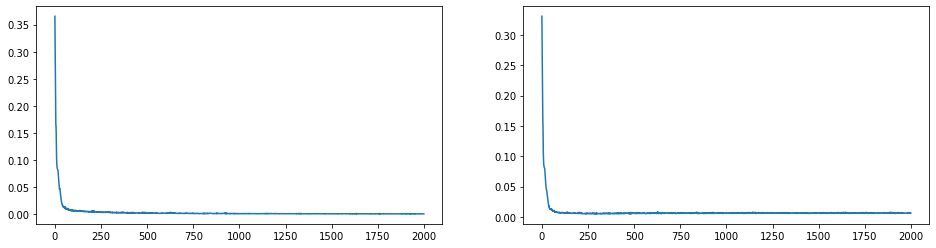

In [10]:
fig = plt.figure(figsize = [16, 4])
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_set)
ax2 = fig.add_subplot(122)
ax2.plot(val_loss_set)

# Evaluation

In [11]:
val_out = val_out.cpu().detach().numpy()
Yt_valid = Yt_valid.cpu().detach().numpy()

In [12]:
net.eval()
m = 0.1

nrmse_loss = bda_utils.nrmse_loss_func(val_out, Yt_valid[:, 0, :], m)
mape_loss = bda_utils.mape_loss_func(val_out, Yt_valid[:, 0, :], m)
smape_loss = bda_utils.smape_loss_func(val_out, Yt_valid[:, 0, :], m)
mae_loss = bda_utils.mae_loss_func(val_out, Yt_valid[:, 0, :], m)

print('NRMSE: %.5f'%nrmse_loss)
print('MAPE: %.5f'%mape_loss)
print('SMAPE: %.5f'%smape_loss)
print('MAE: %.5f'%mae_loss)

NRMSE: 0.08809
MAPE: 0.14142
SMAPE: 0.13043
MAE: 0.06228


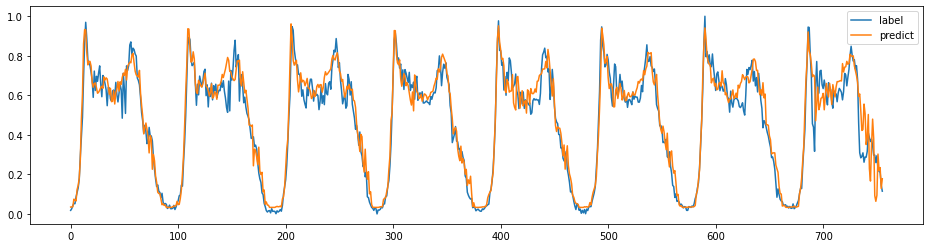

In [13]:
plt.figure(figsize=[16,4])
plt.plot(Yt_valid[:, 0, det], label='label')
plt.plot(val_out[:, det], label='predict')
plt.legend()

In [14]:
torch.save(net.state_dict(), './model/base_for_y_p.pth'%nrmse_loss)